In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./Data/TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [3]:
data['Date'].nunique()

1258

In [4]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

### Part 1 : Univariate example
#### I.e. [previous close prices] -> next_close_price

Text(0.5, 1.0, 'TESLA stock prices')

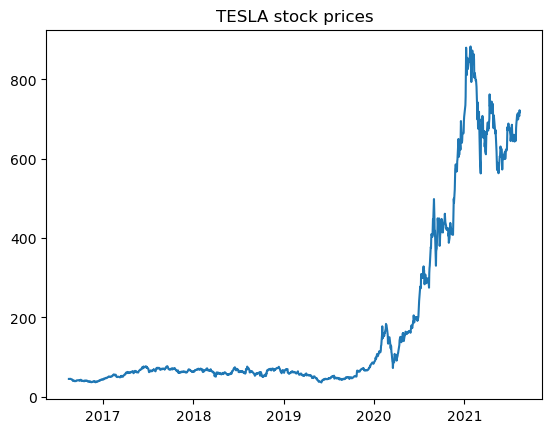

In [6]:
univariate = data[['Date', 'Close']].sort_values(by=['Date'], ascending=True)
plt.plot(univariate['Date'], univariate['Close'])
plt.title('TESLA stock prices')

### Check for stationarity: the statistical properties of a time series (or rather the process generating it) do not change over time
#### Here we use the ADF test:
#### * Calculate test statistics and p-value
#### * If p-value > .05, fail to reject the null Hypothesis, i.e. data is not stationary

In [7]:
adfuller(univariate['Close'])

(0.32732560456343895,
 0.9785640149119201,
 21,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 9440.827811903462)

#### We can see the p-value (0.98) is > 0.05, i.e. the data is not stationary, so we take the difference df.diff() and test for stationarity again

In [8]:
scaler = StandardScaler()
scaler = scaler.fit(univariate['Close'].values.reshape((-1,1)))
univariate['Close_diff'] = scaler.transform(univariate['Close'].values.reshape((-1,1)))
#univariate['Close'].diff()
adfuller(univariate['Close_diff'].fillna(0))

(0.32732560456038345,
 0.9785640149117875,
 21,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 -3957.6754531398474)

### Now we define a function to create sequences of stock prices to predict the following stock price. We will use a timestep of 7, i.e. 7 days previous stock prices to predict the 8th days stock price
#### and rehape into (samples, timestep, variables) required by LSTM

In [9]:
def generate_univariate_sequences(data, time_step=7):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step)]   
        X.append(a)
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [11]:
time_step = 7
n_features = 1
X, y = generate_univariate_sequences(univariate['Close_diff'].fillna(0).values, time_step = time_step)
X = X.reshape((-1, time_step, n_features))
X.shape, y.shape

((1250, 7, 1), (1250,))

#### Now we create train and test splits for our data 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 7, 1), (250, 7, 1), (1000,), (250,))

#### Let's create an LSTM model and fit it to our data

In [15]:
batch_size = 100
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(layers.LSTM(25, return_sequences=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=opt)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 batch_normalization_1 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,126
Trainable params: 18,076
Non-trainable params: 50
_________________________________________________

In [17]:
history = model.fit(X_train, y_train, epochs=1000, 
                    batch_size=batch_size, 
                    validation_split=0.2,
                    verbose=1,
                    shuffle=False)

Epoch 1/1000
8/8 [==============================] - 4s 99ms/step - loss: 1.4308 - val_loss: 1.1079
Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.4916 - val_loss: 1.1032
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.3284 - val_loss: 1.0982
Epoch 4/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.2636 - val_loss: 1.0930
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.2781 - val_loss: 1.0874
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.2240 - val_loss: 1.0814
Epoch 7/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.1901 - val_loss: 1.0750
Epoch 8/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.1350 - val_loss: 1.0684
Epoch 9/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.0481 - val_loss: 1.0615
Epoch 10/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.1311 - val_loss: 1.0540
Epoch 11/

8/8 [==============================] - 0s 10ms/step - loss: 0.3583 - val_loss: 0.0537
Epoch 84/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.3459 - val_loss: 0.0499
Epoch 85/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.3424 - val_loss: 0.0463
Epoch 86/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.3781 - val_loss: 0.0417
Epoch 87/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.3406 - val_loss: 0.0373
Epoch 88/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.3276 - val_loss: 0.0333
Epoch 89/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.3191 - val_loss: 0.0298
Epoch 90/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.3314 - val_loss: 0.0269
Epoch 91/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2977 - val_loss: 0.0243
Epoch 92/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4282 - val_loss: 0.0225
Epoch 93/1000
8/8 [===

8/8 [==============================] - 0s 8ms/step - loss: 0.2986 - val_loss: 0.0123
Epoch 166/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2223 - val_loss: 0.0128
Epoch 167/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2374 - val_loss: 0.0129
Epoch 168/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2455 - val_loss: 0.0132
Epoch 169/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2399 - val_loss: 0.0132
Epoch 170/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2263 - val_loss: 0.0134
Epoch 171/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2541 - val_loss: 0.0132
Epoch 172/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2682 - val_loss: 0.0131
Epoch 173/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2648 - val_loss: 0.0131
Epoch 174/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2355 - val_loss: 0.0130
Epoch 175/1000


8/8 [==============================] - 0s 9ms/step - loss: 0.1723 - val_loss: 0.0116
Epoch 248/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1640 - val_loss: 0.0117
Epoch 249/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1456 - val_loss: 0.0118
Epoch 250/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1597 - val_loss: 0.0116
Epoch 251/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1271 - val_loss: 0.0119
Epoch 252/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1507 - val_loss: 0.0121
Epoch 253/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1724 - val_loss: 0.0125
Epoch 254/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1650 - val_loss: 0.0121
Epoch 255/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1390 - val_loss: 0.0118
Epoch 256/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1439 - val_loss: 0.0117
Epoch 257/1000


8/8 [==============================] - 0s 8ms/step - loss: 0.0850 - val_loss: 0.0126
Epoch 330/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0750 - val_loss: 0.0129
Epoch 331/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0681 - val_loss: 0.0129
Epoch 332/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0627 - val_loss: 0.0126
Epoch 333/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0671 - val_loss: 0.0124
Epoch 334/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0729 - val_loss: 0.0123
Epoch 335/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0731 - val_loss: 0.0125
Epoch 336/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0678 - val_loss: 0.0126
Epoch 337/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0652 - val_loss: 0.0124
Epoch 338/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0671 - val_loss: 0.0122
Epoch 339/1000

8/8 [==============================] - 0s 9ms/step - loss: 0.0417 - val_loss: 0.0102
Epoch 412/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0393 - val_loss: 0.0102
Epoch 413/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0378 - val_loss: 0.0102
Epoch 414/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0458 - val_loss: 0.0102
Epoch 415/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0415 - val_loss: 0.0101
Epoch 416/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0372 - val_loss: 0.0101
Epoch 417/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0427 - val_loss: 0.0101
Epoch 418/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0388 - val_loss: 0.0101
Epoch 419/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0418 - val_loss: 0.0101
Epoch 420/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0416 - val_loss: 0.0101
Epoch 421/100

8/8 [==============================] - 0s 9ms/step - loss: 0.0348 - val_loss: 0.0100
Epoch 494/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0428 - val_loss: 0.0101
Epoch 495/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0396 - val_loss: 0.0100
Epoch 496/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0351 - val_loss: 0.0099
Epoch 497/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0354 - val_loss: 0.0098
Epoch 498/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0369 - val_loss: 0.0100
Epoch 499/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0352 - val_loss: 0.0098
Epoch 500/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0098
Epoch 501/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0338 - val_loss: 0.0098
Epoch 502/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0297 - val_loss: 0.0098
Epoch 503/1000


8/8 [==============================] - 0s 9ms/step - loss: 0.0282 - val_loss: 0.0096
Epoch 576/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0283 - val_loss: 0.0097
Epoch 577/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0334 - val_loss: 0.0097
Epoch 578/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0311 - val_loss: 0.0096
Epoch 579/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0360 - val_loss: 0.0096
Epoch 580/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0352 - val_loss: 0.0096
Epoch 581/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0316 - val_loss: 0.0097
Epoch 582/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0313 - val_loss: 0.0097
Epoch 583/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - val_loss: 0.0096
Epoch 584/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0307 - val_loss: 0.0097
Epoch 585/1000


8/8 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.0094
Epoch 658/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0318 - val_loss: 0.0093
Epoch 659/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0283 - val_loss: 0.0092
Epoch 660/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0316 - val_loss: 0.0092
Epoch 661/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0292 - val_loss: 0.0092
Epoch 662/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0092
Epoch 663/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.0093
Epoch 664/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0353 - val_loss: 0.0096
Epoch 665/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0288 - val_loss: 0.0096
Epoch 666/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0284 - val_loss: 0.0096
Epoch 667/1000


8/8 [==============================] - 0s 9ms/step - loss: 0.0240 - val_loss: 0.0092
Epoch 740/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0266 - val_loss: 0.0092
Epoch 741/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - val_loss: 0.0091
Epoch 742/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0246 - val_loss: 0.0089
Epoch 743/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0296 - val_loss: 0.0089
Epoch 744/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0295 - val_loss: 0.0093
Epoch 745/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0298 - val_loss: 0.0094
Epoch 746/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0303 - val_loss: 0.0090
Epoch 747/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0281 - val_loss: 0.0089
Epoch 748/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0267 - val_loss: 0.0089
Epoch 749/1000


8/8 [==============================] - 0s 9ms/step - loss: 0.0286 - val_loss: 0.0089
Epoch 822/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - val_loss: 0.0085
Epoch 823/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0261 - val_loss: 0.0087
Epoch 824/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0302 - val_loss: 0.0085
Epoch 825/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0311 - val_loss: 0.0086
Epoch 826/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0267 - val_loss: 0.0090
Epoch 827/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0278 - val_loss: 0.0090
Epoch 828/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0315 - val_loss: 0.0087
Epoch 829/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0260 - val_loss: 0.0084
Epoch 830/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0279 - val_loss: 0.0085
Epoch 831/1000

8/8 [==============================] - 0s 8ms/step - loss: 0.0249 - val_loss: 0.0081
Epoch 904/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0273 - val_loss: 0.0081
Epoch 905/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0279 - val_loss: 0.0081
Epoch 906/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0275 - val_loss: 0.0081
Epoch 907/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0275 - val_loss: 0.0081
Epoch 908/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - val_loss: 0.0080
Epoch 909/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0301 - val_loss: 0.0081
Epoch 910/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0302 - val_loss: 0.0081
Epoch 911/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0274 - val_loss: 0.0081
Epoch 912/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0283 - val_loss: 0.0080
Epoch 913/1000

8/8 [==============================] - 0s 8ms/step - loss: 0.0269 - val_loss: 0.0077
Epoch 986/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0274 - val_loss: 0.0077
Epoch 987/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0271 - val_loss: 0.0079
Epoch 988/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0297 - val_loss: 0.0078
Epoch 989/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0276 - val_loss: 0.0077
Epoch 990/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0333 - val_loss: 0.0076
Epoch 991/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - val_loss: 0.0077
Epoch 992/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0268 - val_loss: 0.0076
Epoch 993/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0242 - val_loss: 0.0076
Epoch 994/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0262 - val_loss: 0.0076
Epoch 995/1000


Text(0.5, 1.0, 'Tran vs Val loss')

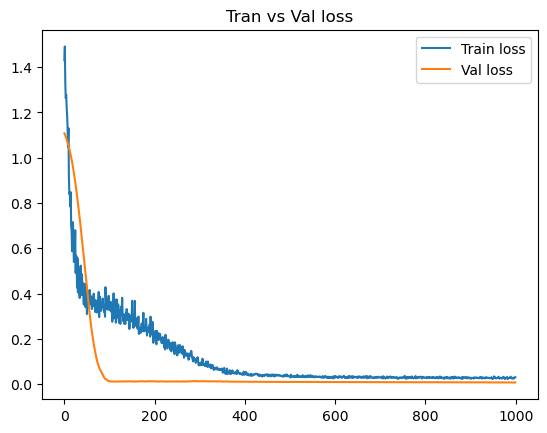

In [43]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.title('Tran vs Val loss')

In [26]:
all_predictions = model.predict(X, batch_size=batch_size)

13/13 [==============================] - 0s 4ms/step


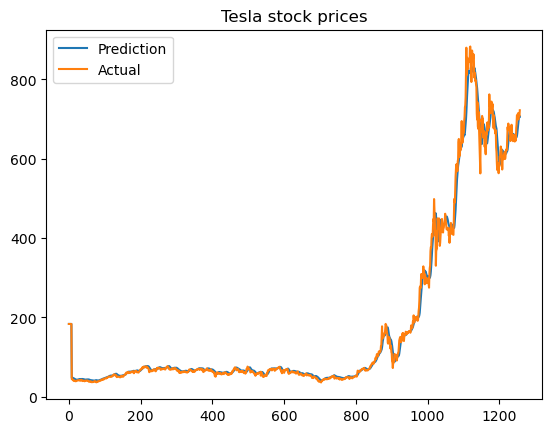

In [42]:
plt.plot(scaler.inverse_transform(np.pad(all_predictions.reshape((-1)), (8,0)).reshape((-1,1))))
plt.plot(scaler.inverse_transform(np.pad(y.reshape((-1)), (8,0)).reshape((-1,1))))
plt.legend(['Prediction', 'Actual'])
plt.title('Tesla stock prices')
plt.show()